In [5]:
import numpy as np
import pandas
import sklearn
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
from sklearn import cluster,datasets, mixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, find, triu
import scipy
from itertools import cycle, islice
from sklearn.gaussian_process.kernels import RBF

In [6]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                    '#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),3)))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

In [7]:
def generateCircles(n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    circles, labels = datasets.make_circles(n_samples=m, factor=.5, noise=n)
    scaler.fit(circles)
    return "nc", scaler.transform(circles), labels, 2
def generateMoons(n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    moons, labels = datasets.make_moons(n_samples=m, noise=n)
    scaler.fit(moons)
    return "nm", scaler.transform(moons), labels, 2
def generateBlobs(n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    #blobs, labels = datasets.make_blobs(n_samples=m, cluster_std=[n + 0.5, n + 1.25, n + 0.25])
    blobs, labels = datasets.make_blobs(n_samples=m, centers=2, cluster_std=[n + 0.5,  n + 0.25])
    scaler.fit(blobs)
    return "nb", scaler.transform(blobs), labels, 2
def generateRandom(n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    no_structure, labels = np.random.rand(m, 2), np.zeros(m)
    scaler.fit(no_structure)
    return "ns", scaler.transform(no_structure), labels, 1

In [8]:
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y
def Sim(Y):
    return np.trace(Y.T@W@Y/np.diag(Y.T@Y))
def Cut(Y):
    return np.trace((1-Y.T)@W@Y/np.diag(Y.T@Y))

## Generate some Data

In [ ]:
r=2
noise = 0.05
m=1500

shape, D, labels, k = generateCircles(n=noise) #generate data
#shape, D, labels, k = generateMoons(n=noise) #generate data
#shape, D, labels, k = generateRandom(n=noise) #generate data
#shape, D, labels, k = generateBlobs(n=noise) #generate data

Clustering by $k$-means

In [21]:
kmeans = KMeans(n_clusters=r)
kmeans.fit(D)
y_km = kmeans.labels_

Text(0.5, 1.0, 'k-means clustering')

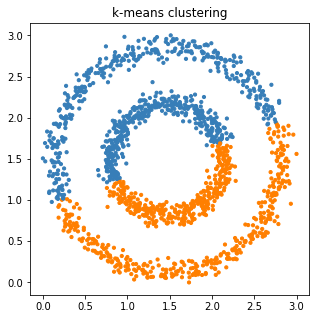

In [24]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[y_km]) 
plt.title("k-means clustering")

# Kernel K Means

In [27]:
def kernel_kmeans(D,r,eps):
    kernel = RBF(eps)
    K=kernel(D)
    Lambda, V = scipy.linalg.eigh(K)
    Lambda[Lambda<0]=0 # Due to numerical instabilities some of the eigenvalues which are close to zero may become negative. We set these eigenvalues here to zero.
    kmeans = KMeans(n_clusters=r)
    A=V*np.power(Lambda,0.5)
    kmeans.fit(A)
    y_pred = kmeans.labels_
    return y_pred, A

In [94]:
eps=0.3 #radius of RBF kernel
y_kkm,A = kernel_kmeans(D,r,eps)

Plot the computed clustering

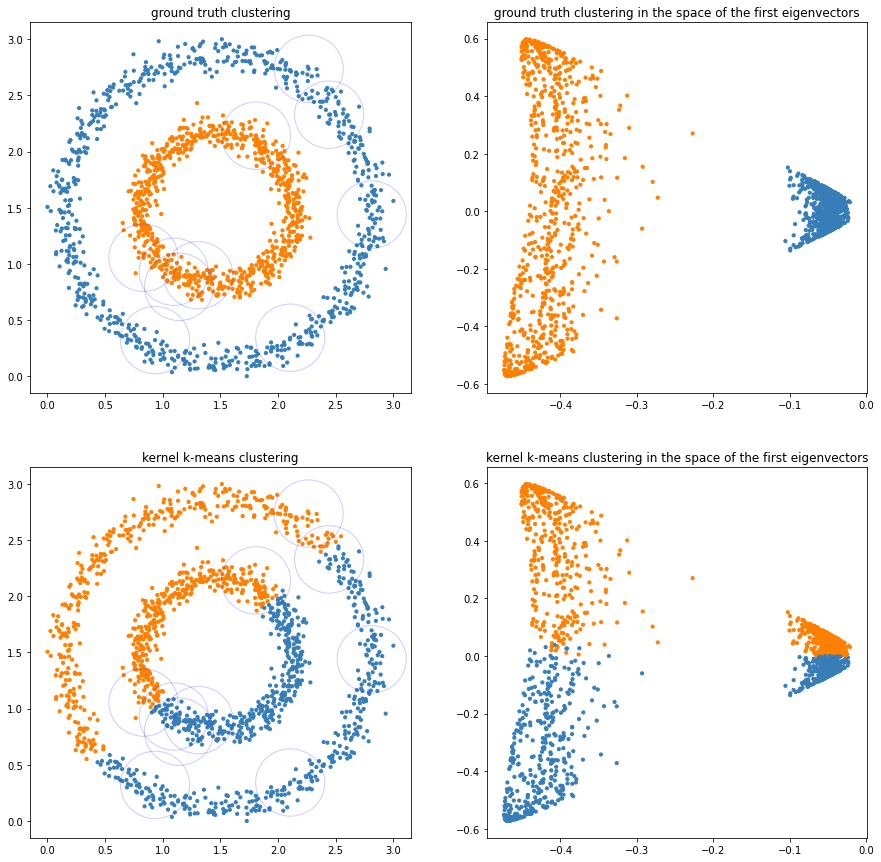

In [95]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[labels]) 
for j in range(0,10):
    circle = plt.Circle((D[j,0], D[j,1]), eps, edgecolor='blue', fill = False, alpha = 0.2)
    ax = fig.gca()
    ax.add_artist(circle)
plt.title("ground truth clustering")

plt.subplot(2, 2, 2)
plt.scatter(A[:, -1], A[:, -2], s=10, color=colors[labels]) 
plt.title("ground truth clustering in the space of the first eigenvectors")

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[y_kkm]) 
for j in range(0,10):
    circle = plt.Circle((D[j,0], D[j,1]), eps, edgecolor='blue', fill = False, alpha = 0.2)
    ax = fig.gca()
    ax.add_artist(circle)
plt.title("kernel k-means clustering")

plt.subplot(2, 2, 4)
plt.scatter(A[:, -1], A[:, -2], s=10, color=colors[y_kkm]) 
plt.title("kernel k-means clustering in the space of the first eigenvectors")
plt.show()

# Spectral Clustering

In [69]:
def spectral_clustering(W,r):
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")

    kmeans = KMeans(n_clusters=k)
    A = V[:,1:]
    kmeans.fit(A)
    y_pred = kmeans.labels_
    return y_pred, A

In [106]:
dataset_pd = pandas.DataFrame(D)
N = kneighbors_graph(dataset_pd, n_neighbors=20,include_self=False, n_jobs=-1)
W = 0.5*(N+N.T)

In [107]:
y_sc_knn, A_sc_knn = spectral_clustering(W,r)

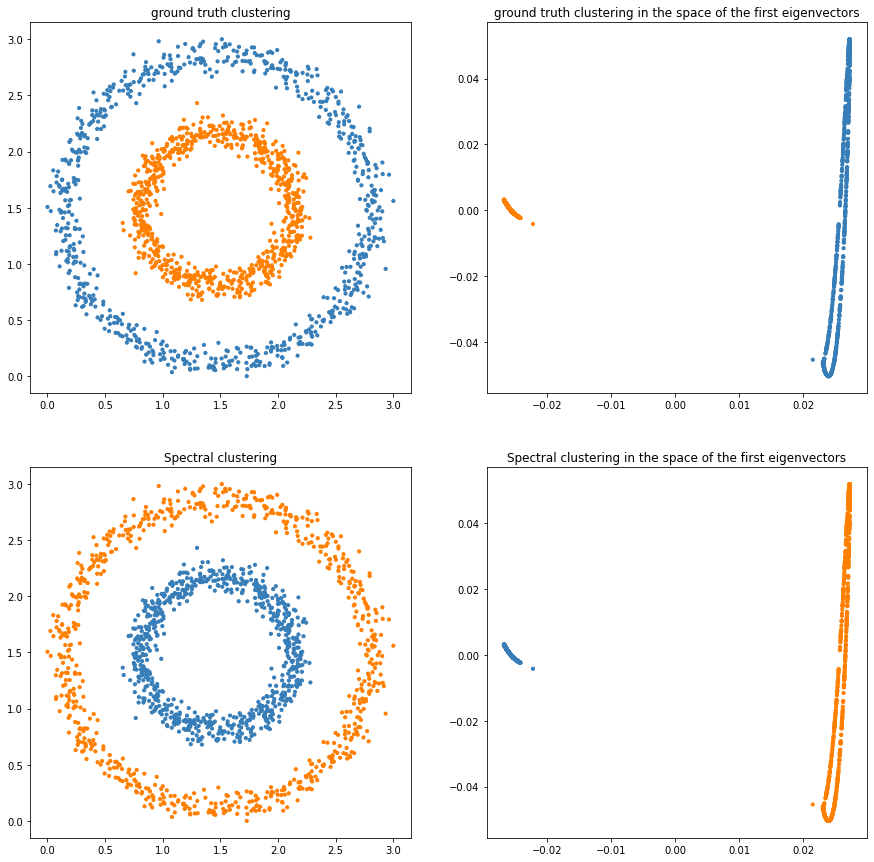

In [108]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[labels]) 
plt.title("ground truth clustering")

plt.subplot(2, 2, 2)
plt.scatter(A_sc_knn[:, 0], A_sc_knn[:, 1], s=10, color=colors[labels]) 
plt.title("ground truth clustering in the space of the first eigenvectors")

plt.subplot(2, 2, 3)
plt.scatter(D[:, 0], D[:, 1], s=10, color=colors[y_sc_knn]) 
plt.title("Spectral clustering")

plt.subplot(2, 2, 4)
plt.scatter(A_sc_knn[:, 0], A_sc_knn[:, 1], s=10, color=colors[y_sc_knn]) 
plt.title("Spectral clustering in the space of the first eigenvectors")
plt.show()

In [109]:
L = np.diag(np.array(W.sum(0))[0]) - W
Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")
Lambda

array([-1.02008517e-15,  1.12792588e-03,  3.40910699e-02])

In [111]:
V

array([[-0.02581989, -0.02635033,  0.00209181],
       [-0.02581989,  0.02618886, -0.01571517],
       [-0.02581989,  0.02498507, -0.04423599],
       ...,
       [-0.02581989, -0.02644409,  0.00239016],
       [-0.02581989,  0.02678598,  0.03844439],
       [-0.02581989, -0.02490684, -0.00129354]])